In [1]:
import numpy as np
import os
from PIL import Image
import pickle
from sum_all_images import Threading_read_images, get_tiff_list
import time
from functools import reduce
from operator import add
import matplotlib.pyplot as plt
from scipy.sparse import vstack, issparse
import inspect
import re
from utils import get_def_name

In [2]:
"""
Hello world
"""
# def get_def_name():
#     # print(f"This message is printed from {inspect.currentframe().f_back.f_code.co_name}")
#     def_name = 'DEF ' + inspect.currentframe().f_back.f_code.co_name + '()'
#     return def_name

# Write a copy of read_all_images() here
def read_all_images_RMS(tiff_path, **kwargs):
    debug = kwargs.get('debug', True)
    image_arrays = []
    start_time = time.time()
    
    if os.path.exists(f'{tiff_path}\\image_arrays.pkl'):
        with open(f'{tiff_path}\\image_arrays.pkl', 'rb') as f:
            image_arrays = pickle.load(f)
        print(f'{tiff_path}\nLoaded image_arrays.pkl')
    else:
        start_time = time.time()

        image_arrays = Threading_read_images(tiff_path)

        with open(f'{tiff_path}\\image_arrays.pkl', 'wb') as f:
            pickle.dump(image_arrays, f)

    end_time = time.time()
    if debug==True:
        print(f'File reading time: {end_time - start_time:.1f} seconds. With {get_def_name()}')


    return image_arrays

def get_tags_from_first_tiff(tiff_path):

    tiff_filenames = get_tiff_list(tiff_path)
    image_first = Image.open(f'{tiff_path}\\{tiff_filenames[0]}')

    # tag 270 Image description
    tag_content = image_first.tag_v2.get(270)

    # Extract exposure time using regular expression
    match = re.search(r'Prop_ExposureTime2=([\d.]+)', tag_content)
    if match:
        exposure_time_str = match.group(1)
        exposure_time_ms = float(exposure_time_str) * 1000
    else:
        print("Exposure time not found in tag 270")

    # tag 258 bit rate (16,) 
    bit_rate = image_first.tag_v2.get(258)

    # tag 256 image width tag 257 image length
    image_width = image_first.tag_v2.get(256)
    image_length = image_first.tag_v2.get(257)
    image_dimension = str(image_width) + "x" + str(image_length)

    output_str = f'Exposure time: {exposure_time_ms:.0f} ms, Bit rate: {bit_rate[0]} bits, Dimension: {image_dimension}, frames: {len(tiff_filenames)}\n'

    return output_str, image_width*image_length


# Mirror of sum_all_images()
# Should create a csr sparse matrix output
def get_RMS_array_csr(tiff_path, **kwargs):
    debug = kwargs.get('debug', False)
    use_pickle = kwargs.get('use_pickle', True)
    
    image_arrays = read_all_images_RMS(tiff_path, **kwargs)


    start_time = time.time()
    if os.path.exists(f'{tiff_path}\\RMS_image_array.pkl') and use_pickle==True:
        with open(f'{tiff_path}\\RMS_image_array.pkl', 'rb') as f:
            RMS_array_csr = pickle.load(f)
        print('Loaded RMS_image_array.pkl')
    
    else:
        square = [img.power(2) for img in image_arrays]
        # check if square is sparse matrix, print the result
        if debug==True:
            print(f'Is square[0] sparse? {type(square[0])}')

        RMS_array_csr = (reduce(add, square) / len(square)).power(0.5)

        with open(f'{tiff_path}\\RMS_image_array.pkl', 'wb') as f:
            pickle.dump(RMS_array_csr, f)

    end_time = time.time()
    if debug==True:
        print(f'Is RMS_array_csr sparse? {type(RMS_array_csr)}')
        print(f'RMS calculation time: {end_time - start_time:.1f} seconds. With {get_def_name()}')
        # 开什么玩笑，要吐了！
        # 应该直接取Image Dimension!
        # print(f'Total RMS_array elements: {RMS_array_csr.size}')
        _, total_pixel_amount = get_tags_from_first_tiff(tiff_path)
        print(f'Total RMS_array elements: {total_pixel_amount}')
        print(f'Non-zero RMS_array elements: {RMS_array_csr.nnz}')
        print(f'Zero RMS_array elements: {total_pixel_amount - RMS_array_csr.nnz}')

    RMS_array = RMS_array_csr.toarray()

    return RMS_array

def add_pixel(image_arrays, **kwargs):

    # square = [img.power(2) for img in image_arrays]
    # RMS = (reduce(add, square) / len(square)).power(0.5)
    RMS = reduce(add, image_arrays)

    return RMS

##### Write a copy of total_pixel_values() to plot RMS

In [3]:
def plot_RMS(RMS_array, tiff_path, **kwargs):
    plot_type = kwargs.get('plot_type', 'bar')
    debug = kwargs.get('debug', True)
    bin_amount = kwargs.get('bin_amount', 100)
    save = kwargs.get('save', False)

    start_time = time.time()
    tiff_filenames = get_tiff_list(tiff_path)

    # RMS_array = RMS_array_csr.toarray()

    caption_tags, image_resolution = get_tags_from_first_tiff(tiff_path)
    caption_statistics_RMS = f'{np.sum(RMS_array==0)} pixels had counted 0 RMS error in total, {np.sum(RMS_array==0) / image_resolution * 100:.1f}%; \n' + \
            f'10% of the pixels had <= {np.percentile(RMS_array, 10)} in RMS errors; \n' + \
            f'90% of the pixels had <= {np.percentile(RMS_array, 90)} in RMS errors'

    if plot_type == 'bar':
        counts, bin_edges = np.histogram(RMS_array.flatten(), bins=bin_amount)

        if debug==True:
            print(f'bin amount: {bin_amount}')
            print(f'bins width: {np.average(np.diff(bin_edges))}')
            max_fraction_bin = np.max(counts) / np.sum(counts)
            print(f'{100*max_fraction_bin:.1f}% of pixel RMS errors fall between '
                f'{np.argmax(counts)} and {np.argmax(counts) + np.diff(bin_edges)[0]} counts in all {len(tiff_filenames)} frames')

        counts_normalized = counts / counts.max()

        fig = plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], counts_normalized, width=np.diff(bin_edges), color='gray', log=True, align='edge')

        plt.xlabel('Counts')
        plt.ylabel('RMS (normalized)')
        
        fig.text(0.15, 0.01, caption_tags + caption_statistics_RMS, ha='left')
        plt.subplots_adjust(bottom=0.2)

        if save==True:
            plt.savefig('RMS_bar.png')

        plt.show()

    elif plot_type == 'heat':
        fig = plt.figure(figsize=(10, 6))
        plt.imshow(RMS_array, cmap='hot', interpolation='nearest')
        plt.colorbar(label='RMS (normalized)')
        fig.text(0.15, 0.01, caption_tags + caption_statistics_RMS, ha='left')
        # plt.subplots_adjust(bottom=0.1)
        if save==True:
            plt.savefig('RMS_heat.png')
        plt.show()

    # elif plot_type=="hist":
        # if debug==True:
        #     print('Minimum non-zero value of image_arrays: %.e' % np.min(RMS_array[RMS_array > 0]))

        # fig = plt.figure(figsize=(10, 6))
        # bin_amount = kwargs.get('bin_amount', 100)
        # if debug==True:
        #     print('amount of bins:', bin_amount)
        # hist = plt.hist(RMS_array.flatten(), bins=bin_amount, color='gray', log=True)
        # if debug==True:
        #     print('hist:', hist)

        # plt.xlabel('Counts')
        # plt.ylabel('RMS')
        # fig.text(0.5, 0.01, caption_tags + caption_statistics_RMS, ha='center') # Add caption to the figure
        # if save==True:
        #     plt.savefig('RMS_hist.png')
        # plt.show()

    end_time = time.time()
    if debug==True:
        print(f'Plotting time: {end_time - start_time:.1f} seconds')

##### Testing

File reading time: 633.4 seconds. With DEF read_all_images_RMS()
Is square[0] sparse? <class 'scipy.sparse._csr.csr_matrix'>
Is RMS_array_csr sparse? <class 'scipy.sparse._csr.csr_matrix'>
RMS calculation time: 234.0 seconds. With DEF get_RMS_array_csr()
Total RMS_array elements: 9437184
Non-zero RMS_array elements: 9436534
Zero RMS_array elements: 650


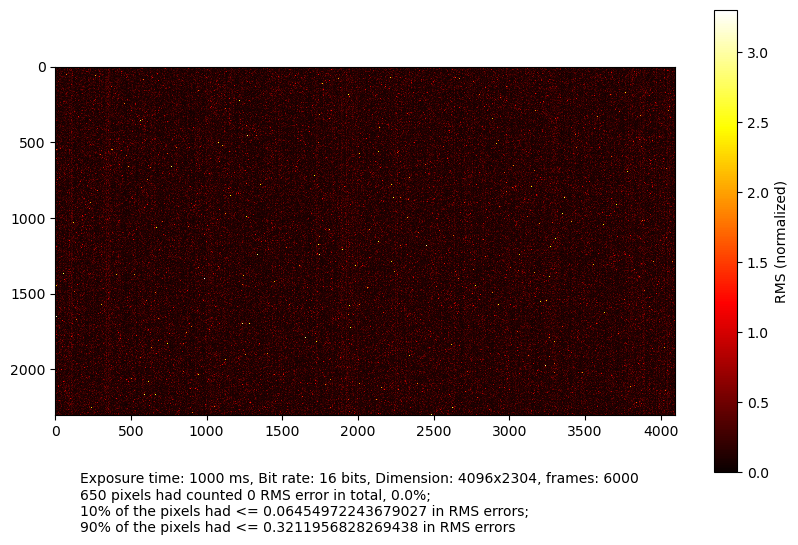

Plotting time: 1.9 seconds
bin amount: 100
bins width: 0.03300606004963331
23.3% of pixel RMS errors fall between 2 and 2.033006060049633 counts in all 6000 frames


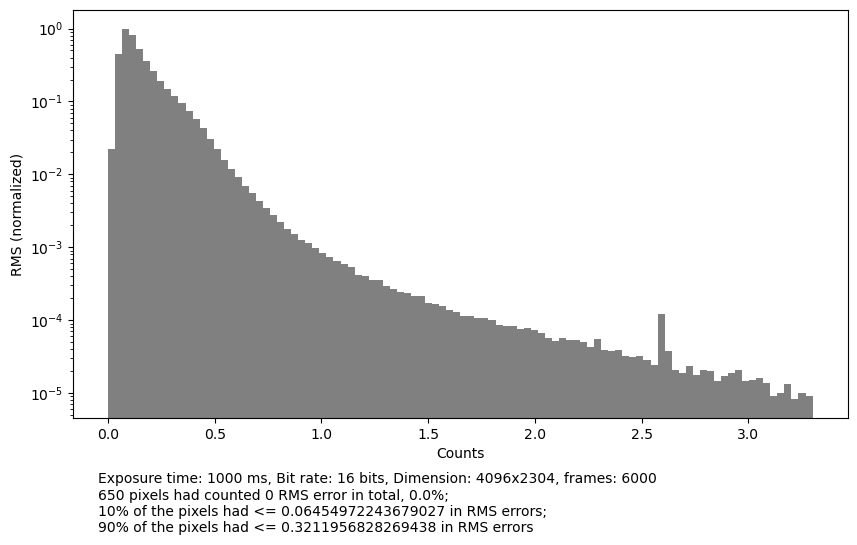

Plotting time: 1.0 seconds


In [4]:
tiff_main_folder = 'C:\\3.12 qCMOS'
tiff_path = tiff_main_folder + '\\full_1s_6000_shot'
# tiff_path = tiff_main_folder + '\\full_200ms_6247shots'
# tiff_path = tiff_main_folder + '\\1024x1024'

RMS_array = get_RMS_array_csr(tiff_path, debug=True)

# print(f'issparse(RMS_array_variable)? {issparse(RMS_array_variable)}')
plot_RMS(RMS_array, tiff_path, plot_type='heat', save=True)
plot_RMS(RMS_array, tiff_path, plot_type='bar', save=True)

In [5]:
# Check if the RMS_array is a sparse matrix
print(type(RMS_array))

# print max and the smallest non-zero element of csr sparse matrix RMS_array with scipy
print('Max element:', RMS_array.max())
print('Min element:', RMS_array.min())
print('Min non-zero element:', RMS_array[RMS_array > 0].min())

<class 'numpy.ndarray'>
Max element: 3.300606004963331
Min element: 0.0
Min non-zero element: 0.012909944487358056
